In [1]:
import gym

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim

In [3]:
import collections

In [4]:
env = gym.make('CartPole-v1')

In [5]:
class Actor(nn.Module):
    def __init__(self, n_actions, space_dims, hidden_dims):
        super(Actor, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(space_dims, hidden_dims),
            nn.ReLU(True),
        )
        self.actor = nn.Sequential(
            nn.Linear(hidden_dims, n_actions),
            nn.Softmax(dim=-1),
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        policy = self.actor(features)
        return policy
    
class Critic(nn.Module):
    def __init__(self, space_dims, hidden_dims):
        super(Critic, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(space_dims, hidden_dims),
            nn.ReLU(True),
        )
        self.critic = nn.Linear(hidden_dims, 1)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        est_reward = self.critic(features)
        return est_reward

In [6]:
class PGLoss(nn.Module):
    def __init__(self):
        super(PGLoss, self).__init__()
    
    def forward(self, action_prob, reward):
        loss = -torch.mean(torch.log(action_prob+1e-6)*reward)
        return loss

In [7]:
def select_action(policy):
    return np.random.choice(len(policy), 1, p=policy)[0]

In [8]:
def to_tensor(x, dtype=None):
    return torch.tensor(x, dtype=dtype).unsqueeze(0)

In [9]:
class ConfigArgs:
    discounted_factor = 0.99
    lr_critic = 0.005
    lr_actor = 0.001
    max_eps = 1000
    sparse_mode = True

args = ConfigArgs()

In [10]:
pg_loss = PGLoss()
mse_loss = nn.MSELoss()
nll_loss = nn.NLLLoss()
xe_loss = nn.CrossEntropyLoss()

In [11]:
actor = Actor(n_actions=env.action_space.n, space_dims=4, hidden_dims=32)
critic = Critic(space_dims=4, hidden_dims=32)

In [12]:
a_optim = torch.optim.Adam(actor.parameters(), lr=args.lr_actor)
c_optim = torch.optim.Adam(critic.parameters(), lr=args.lr_critic)

In [13]:
global_step = 0
n_eps = 0
queue_rewards = collections.deque(maxlen=20)
reward_lst = []
avg_reward_lst = []
mva_lst = []
mva = 0.

while n_eps < args.max_eps:
    n_eps += 1
    next_obs = to_tensor(env.reset(), dtype=torch.float)
    done = False
    score = 0
    while not done:
        obs = next_obs
        a_optim.zero_grad()
        c_optim.zero_grad()
        
        # estimate action with policy network
        policy = actor(obs)
        action = select_action(policy.detach().numpy()[0])
        
        # interaction with environment
        next_obs, reward, done, info = env.step(action)
        
        next_obs = to_tensor(next_obs, dtype=torch.float)
        advantages = torch.zeros_like(policy)
        ext_reward = 0. if args.sparse_mode else reward
        
        v = critic(obs)[0]
        next_v = critic(next_obs)[0]
        if done:
            t_ext_reward = to_tensor([-100], dtype=torch.float) if score < 499 else to_tensor([ext_reward], dtype=torch.float)
            advantages[0, action] = t_ext_reward - v
            c_target = t_ext_reward
        else:
            t_ext_reward = to_tensor([ext_reward], dtype=torch.float)
            advantages[0, action] = t_ext_reward + args.discounted_factor*next_v - v
            c_target = t_ext_reward + args.discounted_factor*next_v
        
        actor_loss = pg_loss(policy, advantages.detach())
        critic_loss = mse_loss(v, c_target.detach())
        loss = actor_loss + critic_loss
        loss.backward()
        a_optim.step()
        c_optim.step()
        
        if not done:
            score += reward
        
        global_step += 1
    
    mva = 0.95*mva + 0.05*score
    queue_rewards.append(score)
    reward_lst.append(score)
    avg_reward_lst.append(np.mean(queue_rewards))
    mva_lst.append(mva)
    print('Episodes: {}, AVG Score: {:.3f}, Score: {}'.format(n_eps, mva, score))

Episodes: 1, AVG Score: 14.000, Score: 14.0
Episodes: 2, AVG Score: 11.500, Score: 9.0
Episodes: 3, AVG Score: 14.667, Score: 21.0
Episodes: 4, AVG Score: 15.500, Score: 18.0
Episodes: 5, AVG Score: 15.800, Score: 17.0
Episodes: 6, AVG Score: 17.667, Score: 27.0
Episodes: 7, AVG Score: 16.571, Score: 10.0
Episodes: 8, AVG Score: 17.625, Score: 25.0
Episodes: 9, AVG Score: 17.889, Score: 20.0
Episodes: 10, AVG Score: 18.700, Score: 26.0
Episodes: 11, AVG Score: 18.182, Score: 13.0
Episodes: 12, AVG Score: 18.333, Score: 20.0
Episodes: 13, AVG Score: 18.692, Score: 23.0
Episodes: 14, AVG Score: 19.786, Score: 34.0
Episodes: 15, AVG Score: 19.267, Score: 12.0
Episodes: 16, AVG Score: 18.750, Score: 11.0
Episodes: 17, AVG Score: 19.941, Score: 39.0
Episodes: 18, AVG Score: 19.389, Score: 10.0
Episodes: 19, AVG Score: 19.263, Score: 17.0
Episodes: 20, AVG Score: 21.300, Score: 60.0
Episodes: 21, AVG Score: 21.300, Score: 14.0
Episodes: 22, AVG Score: 22.300, Score: 29.0
Episodes: 23, AVG Sc

Episodes: 182, AVG Score: 92.300, Score: 73.0
Episodes: 183, AVG Score: 91.500, Score: 61.0
Episodes: 184, AVG Score: 94.350, Score: 121.0
Episodes: 185, AVG Score: 91.150, Score: 58.0
Episodes: 186, AVG Score: 93.350, Score: 125.0
Episodes: 187, AVG Score: 93.500, Score: 71.0
Episodes: 188, AVG Score: 93.950, Score: 79.0
Episodes: 189, AVG Score: 93.800, Score: 62.0
Episodes: 190, AVG Score: 95.650, Score: 121.0
Episodes: 191, AVG Score: 97.600, Score: 88.0
Episodes: 192, AVG Score: 97.000, Score: 87.0
Episodes: 193, AVG Score: 94.300, Score: 51.0
Episodes: 194, AVG Score: 92.500, Score: 59.0
Episodes: 195, AVG Score: 93.300, Score: 100.0
Episodes: 196, AVG Score: 90.800, Score: 75.0
Episodes: 197, AVG Score: 92.600, Score: 132.0
Episodes: 198, AVG Score: 92.450, Score: 57.0
Episodes: 199, AVG Score: 85.350, Score: 65.0
Episodes: 200, AVG Score: 85.050, Score: 60.0
Episodes: 201, AVG Score: 83.250, Score: 120.0
Episodes: 202, AVG Score: 83.950, Score: 87.0
Episodes: 203, AVG Score: 88

Episodes: 361, AVG Score: 56.250, Score: 49.0
Episodes: 362, AVG Score: 55.800, Score: 44.0
Episodes: 363, AVG Score: 53.550, Score: 41.0
Episodes: 364, AVG Score: 55.600, Score: 95.0
Episodes: 365, AVG Score: 55.700, Score: 49.0
Episodes: 366, AVG Score: 53.600, Score: 66.0
Episodes: 367, AVG Score: 54.800, Score: 65.0
Episodes: 368, AVG Score: 56.650, Score: 80.0
Episodes: 369, AVG Score: 58.150, Score: 75.0
Episodes: 370, AVG Score: 58.850, Score: 53.0
Episodes: 371, AVG Score: 60.800, Score: 128.0
Episodes: 372, AVG Score: 62.900, Score: 82.0
Episodes: 373, AVG Score: 70.200, Score: 211.0
Episodes: 374, AVG Score: 73.950, Score: 118.0
Episodes: 375, AVG Score: 76.500, Score: 86.0
Episodes: 376, AVG Score: 75.750, Score: 46.0
Episodes: 377, AVG Score: 76.600, Score: 50.0
Episodes: 378, AVG Score: 76.900, Score: 60.0
Episodes: 379, AVG Score: 76.300, Score: 50.0
Episodes: 380, AVG Score: 74.850, Score: 49.0
Episodes: 381, AVG Score: 75.600, Score: 64.0
Episodes: 382, AVG Score: 76.55

Episodes: 539, AVG Score: 63.150, Score: 118.0
Episodes: 540, AVG Score: 62.600, Score: 40.0
Episodes: 541, AVG Score: 62.700, Score: 60.0
Episodes: 542, AVG Score: 62.000, Score: 44.0
Episodes: 543, AVG Score: 66.250, Score: 136.0
Episodes: 544, AVG Score: 66.350, Score: 47.0
Episodes: 545, AVG Score: 65.100, Score: 56.0
Episodes: 546, AVG Score: 67.050, Score: 97.0
Episodes: 547, AVG Score: 67.850, Score: 59.0
Episodes: 548, AVG Score: 67.600, Score: 42.0
Episodes: 549, AVG Score: 68.000, Score: 53.0
Episodes: 550, AVG Score: 66.800, Score: 62.0
Episodes: 551, AVG Score: 64.900, Score: 58.0
Episodes: 552, AVG Score: 65.350, Score: 109.0
Episodes: 553, AVG Score: 65.850, Score: 86.0
Episodes: 554, AVG Score: 73.050, Score: 209.0
Episodes: 555, AVG Score: 74.000, Score: 66.0
Episodes: 556, AVG Score: 73.950, Score: 55.0
Episodes: 557, AVG Score: 76.150, Score: 84.0
Episodes: 558, AVG Score: 76.950, Score: 58.0
Episodes: 559, AVG Score: 74.400, Score: 67.0
Episodes: 560, AVG Score: 75.0

Episodes: 714, AVG Score: 339.900, Score: 499.0
Episodes: 715, AVG Score: 350.850, Score: 499.0
Episodes: 716, AVG Score: 362.500, Score: 499.0
Episodes: 717, AVG Score: 375.850, Score: 499.0
Episodes: 718, AVG Score: 379.250, Score: 293.0
Episodes: 719, AVG Score: 377.750, Score: 218.0
Episodes: 720, AVG Score: 375.450, Score: 206.0
Episodes: 721, AVG Score: 368.550, Score: 145.0
Episodes: 722, AVG Score: 359.000, Score: 163.0
Episodes: 723, AVG Score: 344.000, Score: 141.0
Episodes: 724, AVG Score: 326.100, Score: 141.0
Episodes: 725, AVG Score: 311.100, Score: 145.0
Episodes: 726, AVG Score: 302.150, Score: 140.0
Episodes: 727, AVG Score: 298.250, Score: 153.0
Episodes: 728, AVG Score: 294.150, Score: 155.0
Episodes: 729, AVG Score: 290.750, Score: 167.0
Episodes: 730, AVG Score: 281.350, Score: 204.0
Episodes: 731, AVG Score: 267.250, Score: 159.0
Episodes: 732, AVG Score: 256.300, Score: 216.0
Episodes: 733, AVG Score: 242.900, Score: 216.0
Episodes: 734, AVG Score: 232.000, Score

Episodes: 885, AVG Score: 236.550, Score: 360.0
Episodes: 886, AVG Score: 238.800, Score: 246.0
Episodes: 887, AVG Score: 242.700, Score: 280.0
Episodes: 888, AVG Score: 243.300, Score: 230.0
Episodes: 889, AVG Score: 247.550, Score: 278.0
Episodes: 890, AVG Score: 253.000, Score: 296.0
Episodes: 891, AVG Score: 267.800, Score: 499.0
Episodes: 892, AVG Score: 269.300, Score: 221.0
Episodes: 893, AVG Score: 271.450, Score: 251.0
Episodes: 894, AVG Score: 275.800, Score: 284.0
Episodes: 895, AVG Score: 276.750, Score: 212.0
Episodes: 896, AVG Score: 276.700, Score: 202.0
Episodes: 897, AVG Score: 275.950, Score: 199.0
Episodes: 898, AVG Score: 276.150, Score: 220.0
Episodes: 899, AVG Score: 276.450, Score: 217.0
Episodes: 900, AVG Score: 277.750, Score: 245.0
Episodes: 901, AVG Score: 283.350, Score: 327.0
Episodes: 902, AVG Score: 285.500, Score: 319.0
Episodes: 903, AVG Score: 284.500, Score: 305.0
Episodes: 904, AVG Score: 281.000, Score: 429.0
Episodes: 905, AVG Score: 287.950, Score

## Visualization

In [14]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

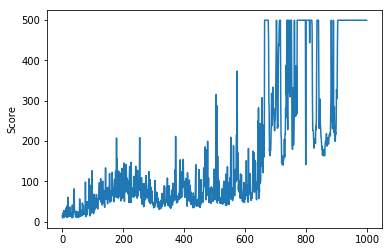

In [15]:
plt.plot(reward_lst)
plt.ylabel('Score')
plt.show()

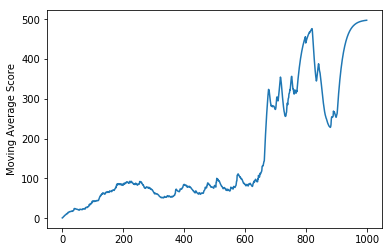

In [16]:
plt.plot(mva_lst)
plt.ylabel('Moving Average Score')
plt.show()

In [17]:
np.save('a2c-mva-2.npy', np.array(mva_lst))